In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
traindf= pd.read_csv("train.csv")
testdf= pd.read_csv("test.csv")

In [3]:
traindf.var()

PassengerId    66231.000000
Survived           0.236772
Pclass             0.699015
Age              211.019125
SibSp              1.216043
Parch              0.649728
Fare            2469.436846
dtype: float64

In [4]:
for k in traindf.keys():
    print('{0}: {1}'.format(k, len(traindf[k].unique())))

PassengerId: 891
Survived: 2
Pclass: 3
Name: 891
Gender: 2
Age: 89
SibSp: 7
Parch: 7
Ticket: 681
Fare: 248
Cabin: 148
Embarked: 4


In [5]:
for k in traindf.keys():
    if len(traindf[k].unique())<=10:
        print(k)

Survived
Pclass
Gender
SibSp
Parch
Embarked


In [6]:
import math
def forAge(row):
    if row['Age'] < 10:
        return '<10'
    elif math.isnan(row['Age']):
        return "nan"
    else:
        dec = str(int(row['Age']/10))
        return "{0}0's".format(dec)
decade=traindf.apply(forAge, axis=1)
print("Decade: {1}".format(k, len(decade.unique())))

Decade: 10


In [7]:
import numpy as np
def pretreat(df):
    # create a df with discrete variables (len<10)
    filt=[k for k in df.keys() if len(df[k].unique())<=10]
    filtr2=df[filt].copy()
    forAge = lambda row: int(row['Age']/10) if not math.isnan(row['Age']) else np.nan
    filtr2['Decade']=df.apply(forAge, axis=1) 
    filtr2=filtr2.dropna()    
    filtr2['Decade']=filtr2['Decade'].astype('int32')
    return filtr2

In [8]:
ptraindf= pretreat(traindf)
ptestdf=pretreat(testdf)

In [9]:
ptraindf.to_csv('post_train.csv', index=False)
ptestdf.to_csv( 'post_test.csv', index=False)

In [10]:
import pyAgrum as gum
import matplotlib.pyplot as plt
import pyAgrum.lib.notebook as gnb

In [11]:
df=pd.read_csv('post_train.csv')
for k in df.keys():
    print("{} : {}".format(k, df[k].unique()))

Survived : [0 1]
Pclass : [3 1 2]
Gender : ['male' 'female']
SibSp : [1 0 3 4 2 5]
Parch : [0 1 2 5 3 4 6]
Embarked : ['S' 'C' 'Q']
Decade : [2 3 5 0 1 4 6 7 8]


In [17]:
template=gum.BayesNet()
template.add(gum.RangeVariable("Survived", "Survived",0,1))
template.add(gum.RangeVariable("Pclass", "Pclass",1,3))
template.add(gum.LabelizedVariable("Gender", "Gender",0).addLabel("female").addLabel("male"))
template.add(gum.RangeVariable("SibSp", "SibSp",0,8))
template.add(gum.RangeVariable("Parch", "Parch",0,9))
template.add(gum.LabelizedVariable("Embarked", "Embarked",0).addLabel('').addLabel('C').addLabel('Q').addLabel('S'))
template.add(gum.RangeVariable("Decade", "Calculated decade", 0,9))           
gnb.showBN(template)

In [18]:
learner = gum.BNLearner('post_train.csv', template)
bn = learner.learnBN()
bn

(gum::BayesNet<double>@0x21a2730) BN{nodes: 7, arcs: 7, domainSize: 43200, parameters: 248, compression ratio: 99% }

In [19]:
gnb.showInformation(bn,{},size="20")

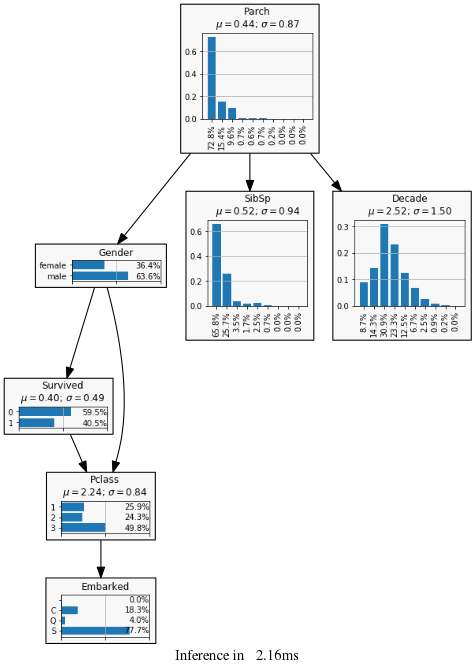

In [20]:
gnb.showInference(bn)


In [ ]:
gnb.showPosterior(bn,evs={},target='Survived')


In [ ]:
gnb.showPosterior(bn,evs={"Sex": "male", "Decade": 3},target='Survived')


In [ ]:
gnb.showPosterior(bn,evs={"Sex": "female", "Decade": 8},target='Survived')


In [ ]:
gnb.sideBySide(bn, gum.MarkovBlanket(bn, 'Survived'), captions=["Learned Bayesian Network", "Markov blanket of 'Survived'"])


In [ ]:
from pyAgrum.lib.bn2roc import showROC
showROC(bn, 'post_train.csv','Survived',"1",True,True)

In [ ]:
vars=[var for var in ptestdf.keys() if var != "Survived" ]
ie=gum.LazyPropagation(bn)
testdf=pd.read_csv('post_test.csv')

def init_belief():
    # Initialize evidence
    for var in vars:
        ie.addEvidence(var, 0)

def update_beliefs(row):
    # Update beliefs from a given row less the Survived variable
    for var in vars:
        label = str(row.to_dict()[var])
        idx = bn.variable(var).index(str(row.to_dict()[var]))
        ie.chgEvidence(var, idx)
    ie.makeInference()
    
def is_well_predicted(row):
    update_beliefs(row)
    marginal = ie.posterior('Survived')
    outcome = row.to_dict()['Survived']
    if outcome == 0: # Did not survived
        if marginal.toarray()[1] < 0.46576681:
            return "True Positive"
        else:
            return "False Negative"
    else: # Survived
        if marginal.toarray()[1] >= 0.46576681:
            return "True Negative"
        else:
            return "False Positive"

init_belief()
ie.addTarget('Survived')

result = testdf.apply(is_well_predicted, axis=1)

result.value_counts(True)

NameError: name 'getpwd' is not defined